In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import xgboost as xgb
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, auc
from trainer_lib.transformers import (
    CategoricalLimitTransformer, 
    SelectColumnsTransfomer,
    CallDurationTransformer, 
    TimeOfDayTransformer, 
    MonthNameTransformer,
    DatasetCleanerTransformer)

In [9]:
from trainer_lib import DataManager
# The instantiation will fetch the data and documentation
mngr = DataManager(save_path="../data/raw/", report_path="../reports/")
X,y = mngr.train

In [10]:
# Model columns
model_columns = [
    "Age", 
    "Job", 
    "Marital", 
    "Education", 
    "Default", 
    "HHInsurance",
    "CarLoan", 
    "Communication", 
    "LastContactDay", 
    "LastContactMonth",
    "NoOfContacts", 
    "DaysPassed", 
    "PrevAttempts", 
    "Outcome", 
    "CallDurationMins", 
    "CallTimeOfDay"
]

# Get categorical and numeric column names
datatype = X.dtypes
categorical = [c for c in datatype[datatype == 'object'].index.to_list() if c in model_columns]
numeric = [n for n in datatype[~datatype.index.isin(categorical)].index.to_list() if n in model_columns]

# Feature engineering pipeline
feature_engineering = Pipeline([
    ("category_trimmer", CategoricalLimitTransformer(3, columns=['Job'])),
    ("add_time_duration", CallDurationTransformer()),
    ("add_time_of_day", TimeOfDayTransformer()),
    ("convert_month", MonthNameTransformer()),
    ("clean_missing", DatasetCleanerTransformer()),
    ("column_selection", SelectColumnsTransfomer(columns=model_columns))
])

In [11]:
# Define individual transformers in a pipeline
categorical_preprocessing = Pipeline([('ohe', OneHotEncoder())])
numerical_preprocessing = Pipeline([('scaler', StandardScaler())])

# Define which transformer applies to which columns
preprocess = ColumnTransformer([
    ('categorical_preprocessing', categorical_preprocessing, categorical),
    ('numerical_preprocessing', numerical_preprocessing, numeric)
])

In [47]:
data_pipeline = Pipeline([
    ( 'feature_engineering', feature_engineering),
    ( "encoder", preprocess),
])

model_pipe = Pipeline([
    ("pre_processing", data_pipeline),
    ('model', xgb.XGBClassifier(objective='binary:logistic'))
])

In [48]:
model_pipe

Pipeline(steps=[('pre_processing',
                 Pipeline(steps=[('feature_engineering',
                                  Pipeline(steps=[('category_trimmer',
                                                   CategoricalLimitTransformer(columns=['Job'],
                                                                               n=3)),
                                                  ('add_time_duration',
                                                   CallDurationTransformer()),
                                                  ('add_time_of_day',
                                                   TimeOfDayTransformer()),
                                                  ('convert_month',
                                                   <trainer_lib.transformers.dataframe_transformers.MonthNameTransformer object at 0x7f87...
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
             

In [49]:
model_pipe.fit(X, y.values)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[21:33:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('pre_processing',
                 Pipeline(steps=[('feature_engineering',
                                  Pipeline(steps=[('category_trimmer',
                                                   CategoricalLimitTransformer(columns=['Job'],
                                                                               n=3)),
                                                  ('add_time_duration',
                                                   CallDurationTransformer()),
                                                  ('add_time_of_day',
                                                   TimeOfDayTransformer()),
                                                  ('convert_month',
                                                   <trainer_lib.transformers.dataframe_transformers.MonthNameTransformer object at 0x7f87...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                       

In [77]:
names = list(model_pipe['pre_processing']['encoder'].transformers_[0][1]['ohe'].get_feature_names(categorical))
names.extend(numeric)
# .transformers_[1][1]['onehot']\
#                    .get_feature_names(categorical_features)
names

['Job_blue-collar',
 'Job_management',
 'Job_other',
 'Marital_divorced',
 'Marital_married',
 'Marital_single',
 'Education_primary',
 'Education_secondary',
 'Education_tertiary',
 'Education_unknown',
 'Communication_cellular',
 'Communication_missing',
 'Communication_telephone',
 'LastContactMonth_-1',
 'Outcome_failure',
 'Outcome_not_contacted',
 'Outcome_other',
 'Outcome_success',
 'Age',
 'Default',
 'HHInsurance',
 'CarLoan',
 'LastContactDay',
 'NoOfContacts',
 'DaysPassed',
 'PrevAttempts']

In [67]:
X_test,y_test = mngr.test
preds = model_pipe.predict_proba(X_test)

In [68]:
preds

array([[0.8966935 , 0.10330647],
       [0.36977077, 0.63022923],
       [0.76177627, 0.23822372],
       ...,
       [0.41347748, 0.5865225 ],
       [0.91287833, 0.08712164],
       [0.16448742, 0.8355126 ]], dtype=float32)

In [61]:
X_trans[3]

array([ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  0.        , -1.40402638, -0.12129857,
        1.01460667, -0.39166636, -0.56043541, -0.19820024, -0.46597493,
       -0.34521959])

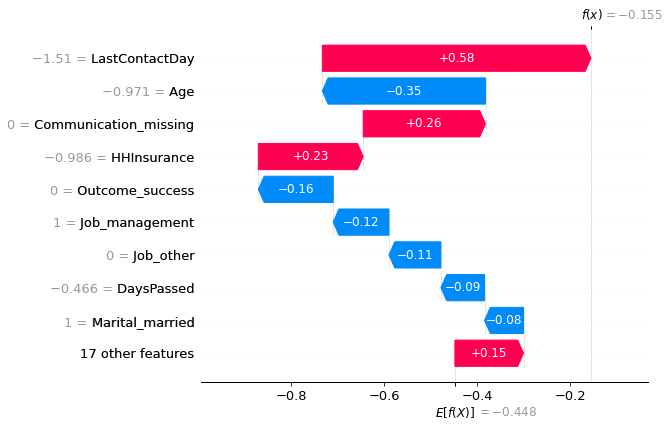

In [84]:
import shap
import pandas as pd
explainer = shap.Explainer(model_pipe.named_steps["model"])
X_tran_df = pd.DataFrame(data_pipeline.fit_transform(X, y), columns=names)
shap_values = explainer(X_tran_df, y)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[4])

In [64]:
shap_values.shape

(4000, 26)

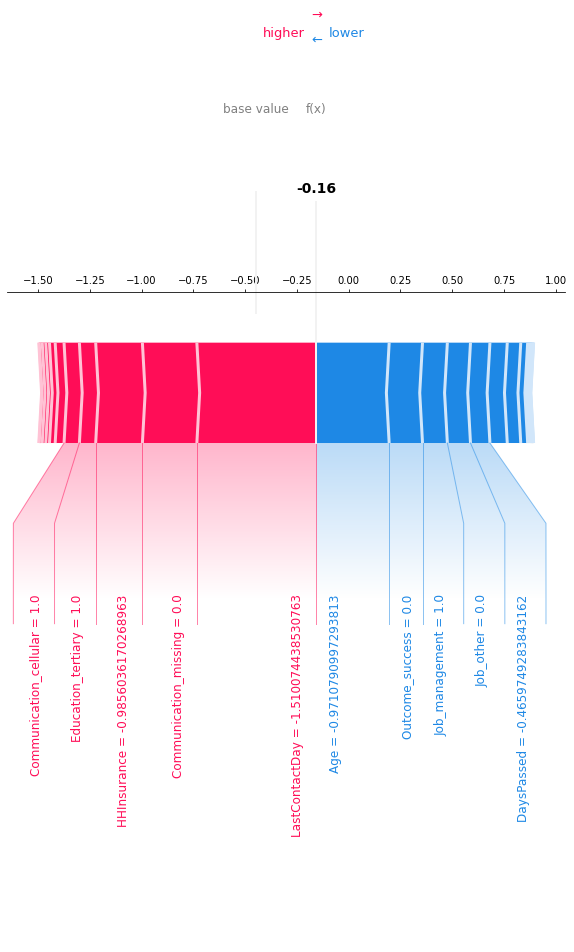

In [83]:
p = shap.plots.force(shap_values[4])
p.matplotlib((10,12),True,90)

In [41]:
y_test

,CarInsurance
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
995,NaN
996,NaN
997,NaN
998,NaN


In [24]:
accuracy_score(y_test, preds)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
train_t.head()

In [ ]:
from collections import defaultdict

In [17]:
mapper = defaultdict(lambda: 'other')

In [18]:
mapper['hello'] = 'hello'

In [19]:
mapper

defaultdict(<function __main__.<lambda>()>, {'hello': 'hello'})

In [21]:
mapper['hello']

'hello'